In [2]:
# Basic
import numpy as np
from scipy import stats
import pandas as pd
from patsy import bs, dmatrix
import matplotlib.pyplot as plt
# Exploratory Analysis of Bayesian Models
import arviz as az
# Probabilistic programming languages
import bambi as bmb
import pymc as pm
import tensorflow_probability as tfp
tfd = tfp.distributions
az.style.use("arviz-grayscale")
plt.rcParams['figure.dpi'] = 300
np.random.seed(5201)
viridish = [(0.2823529411764706, 0.11372549019607843, 0.43529411764705883, 1.0),
            (0.1450980392156863, 0.6705882352941176, 0.5098039215686274, 1.0),
            (0.6901960784313725, 0.8666666666666667, 0.1843137254901961, 1.0)]

# Diagnosing Numerical Inference

In [7]:
# Good chain vs 2 bad chains

good_chains = stats.beta.rvs(2, 5, size=(2, 2000))
bad_chains0 = np.random.normal(np.sort(good_chains, axis=None), 0.05, size=4000).reshape(2, -1)

bad_chains1 = good_chains.copy()
for i in np.random.randint(1900, size=4):
    bad_chains1[i%2:, i:i+100] = np.random.beta(i, 950, size=100)

chains = { "good_chains": good_chains, 
          "bad_chains0": bad_chains0,
          "bad_chains1": bad_chains1}


In [8]:
az.ess(chains)

<xarray.Dataset> Size: 24B
Dimensions:      ()
Data variables:
    good_chains  float64 8B 4.389e+03
    bad_chains0  float64 8B 2.436
    bad_chains1  float64 8B 111.1

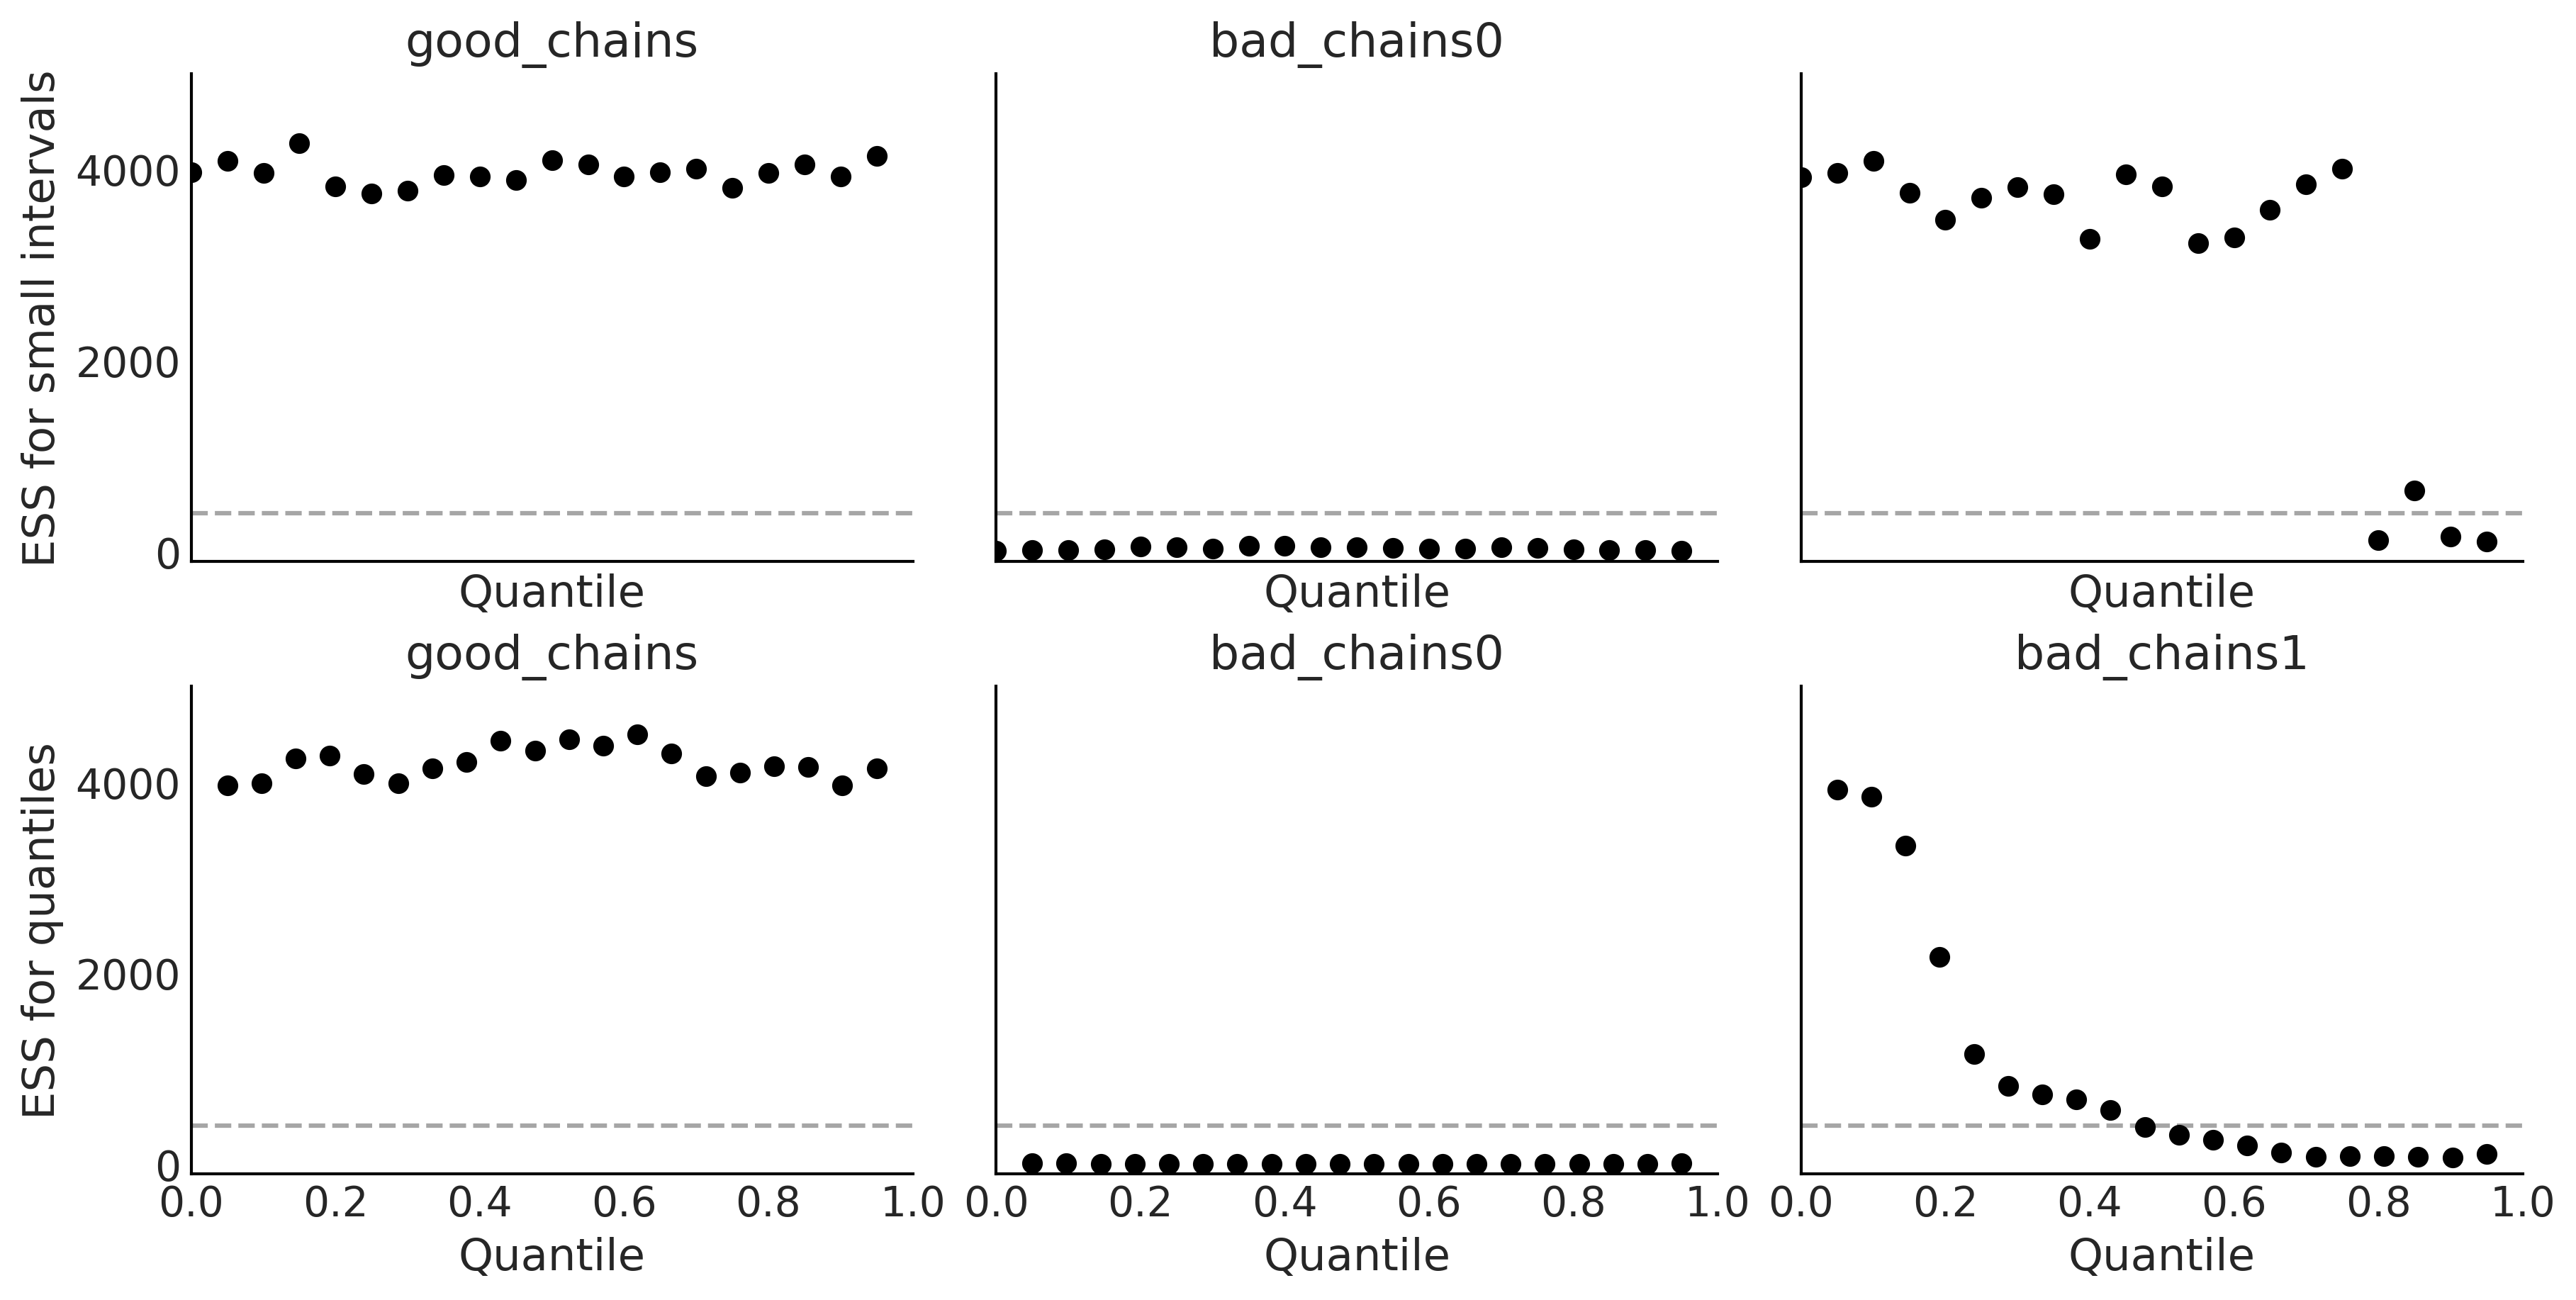

In [72]:
import warnings
## Quick fix for package version errors
warnings.filterwarnings("ignore")

_, axes = plt.subplots(2, 3, figsize=(12, 6), sharey=True, sharex=True)
az.plot_ess(chains, kind="local", ax=axes[0])
az.plot_ess(chains, kind="quantile", ax=axes[1])

for ax_ in axes[0]:
    ax_.set_label("")
for ax in axes[1]:
    ax_.set_title("")
for ax_ in axes[:, 1:].ravel():
    ax_.set_ylabel("")

plt.ylim(-100, 5000)
plt.savefig("img/chap02/plot_ess.png")

In [73]:
az.rhat(chains)

<xarray.Dataset> Size: 24B
Dimensions:      ()
Data variables:
    good_chains  float64 8B 1.0
    bad_chains0  float64 8B 2.408
    bad_chains1  float64 8B 1.033

array([[<Axes: title={'center': 'good_chains'}>,
        <Axes: title={'center': 'good_chains'}>],
       [<Axes: title={'center': 'bad_chains0'}>,
        <Axes: title={'center': 'bad_chains0'}>],
       [<Axes: title={'center': 'bad_chains1'}>,
        <Axes: title={'center': 'bad_chains1'}>]], dtype=object)

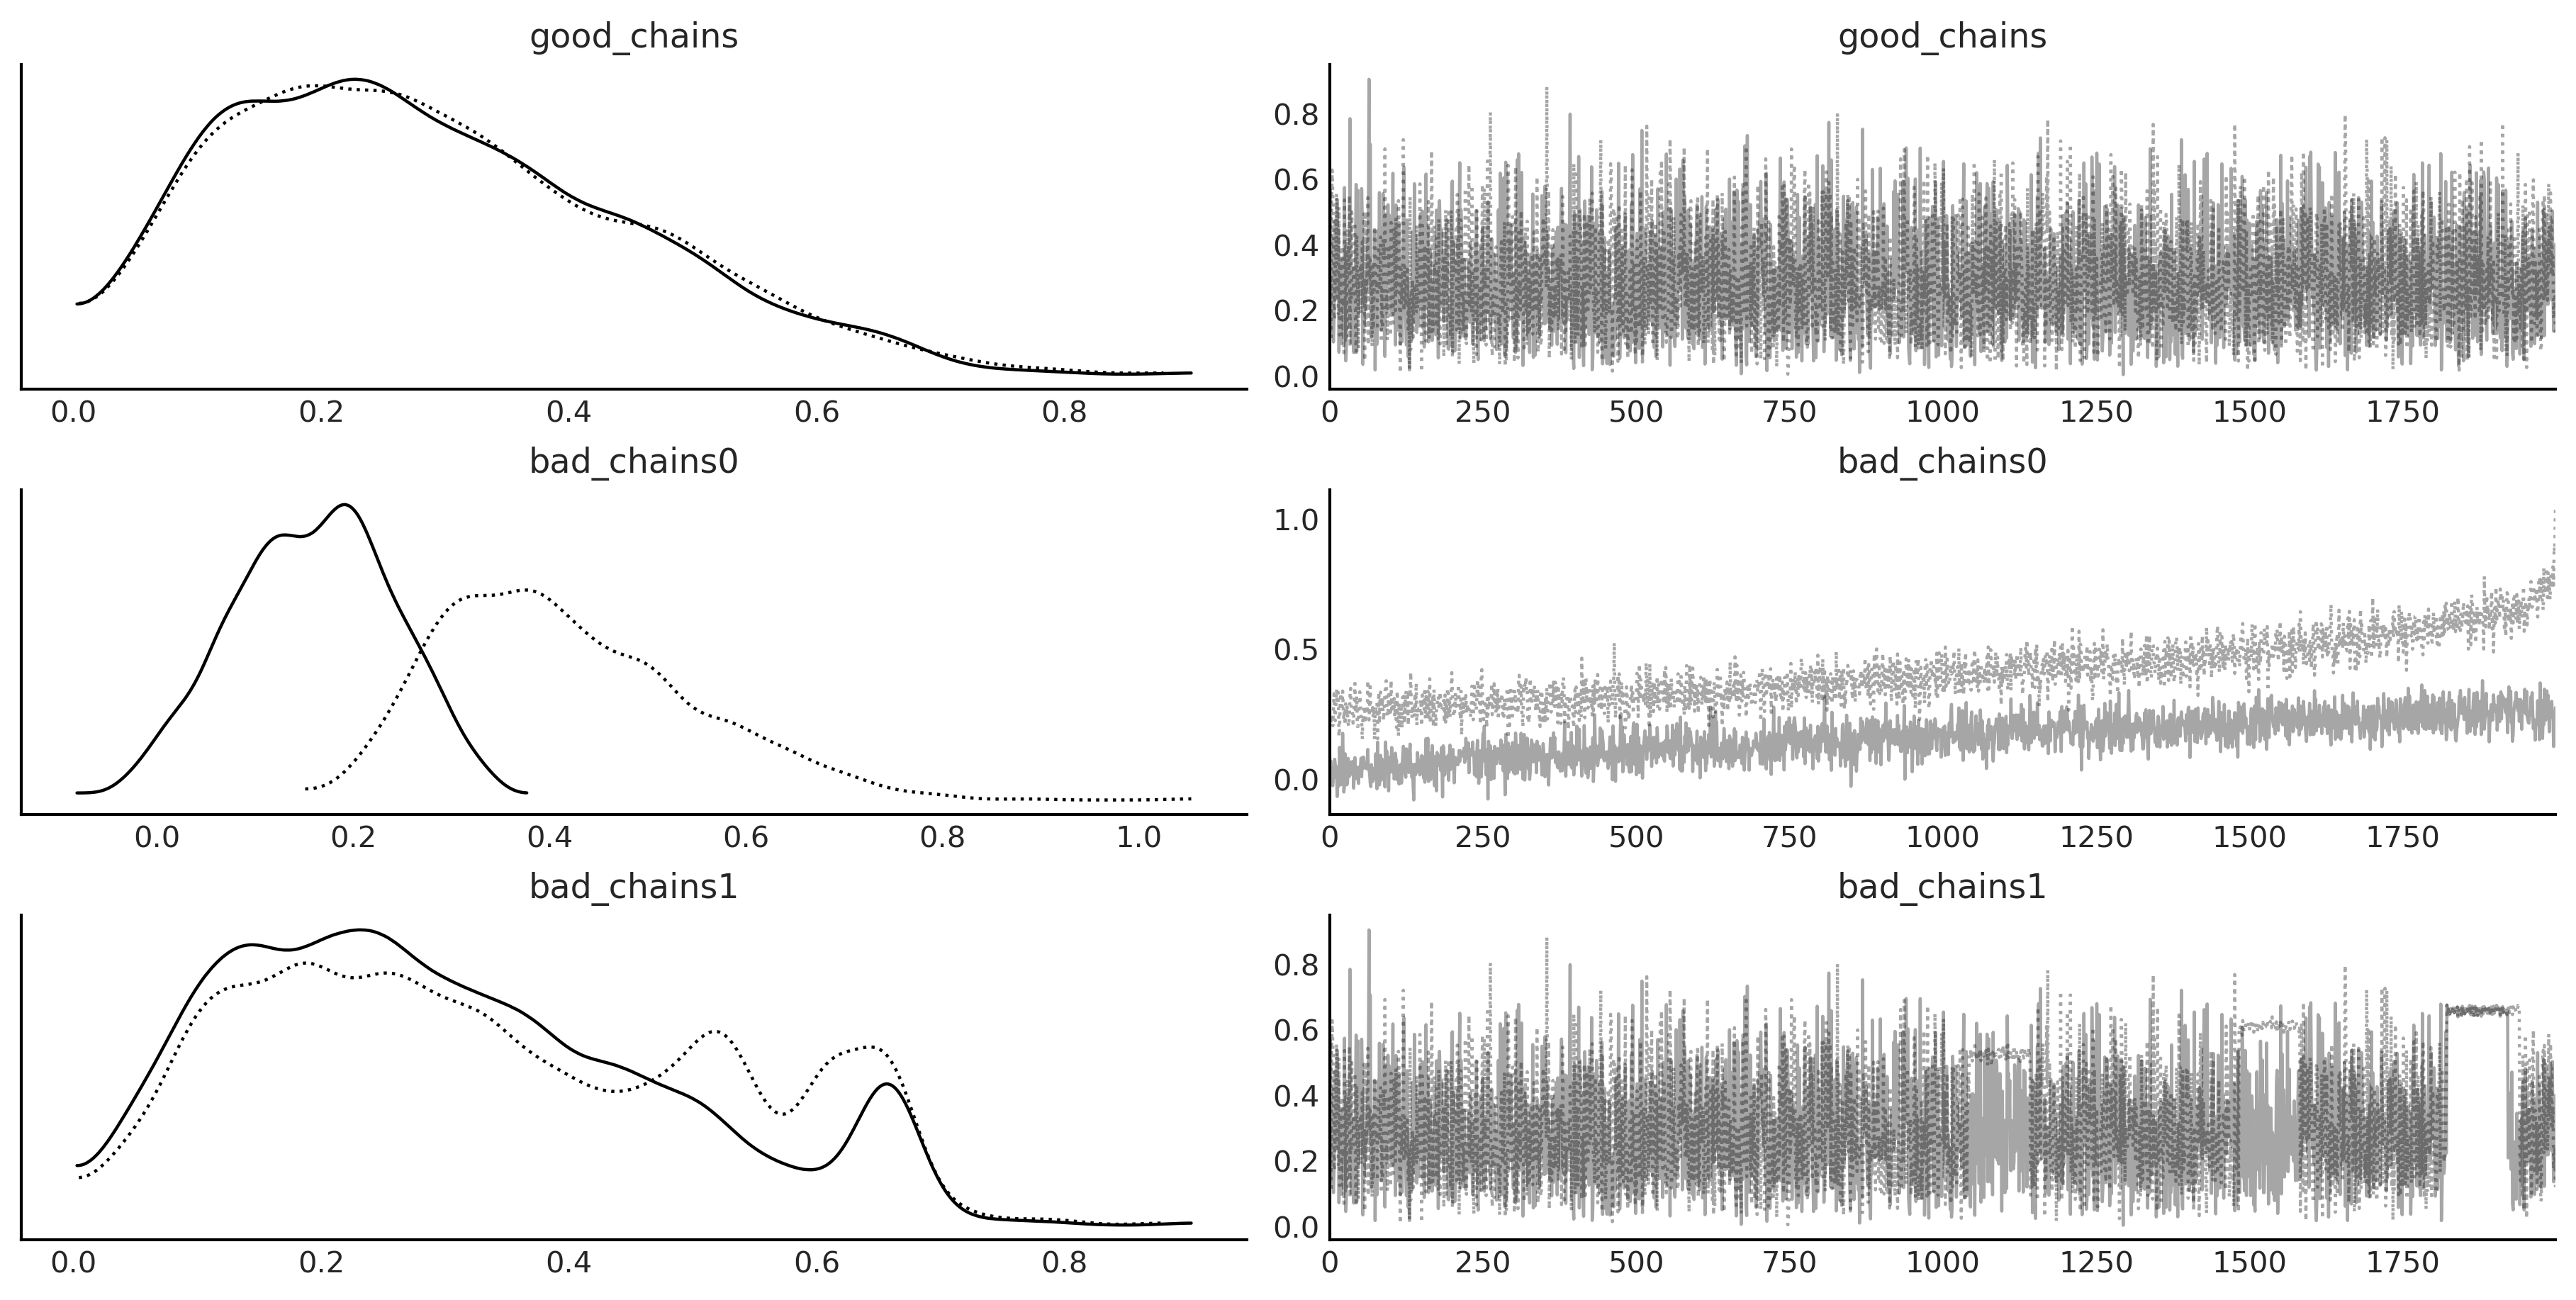

In [74]:
az.plot_trace(chains)

array([<Axes: title={'center': 'good_chains'}>,
       <Axes: title={'center': 'bad_chains0'}>,
       <Axes: title={'center': 'bad_chains1'}>], dtype=object)

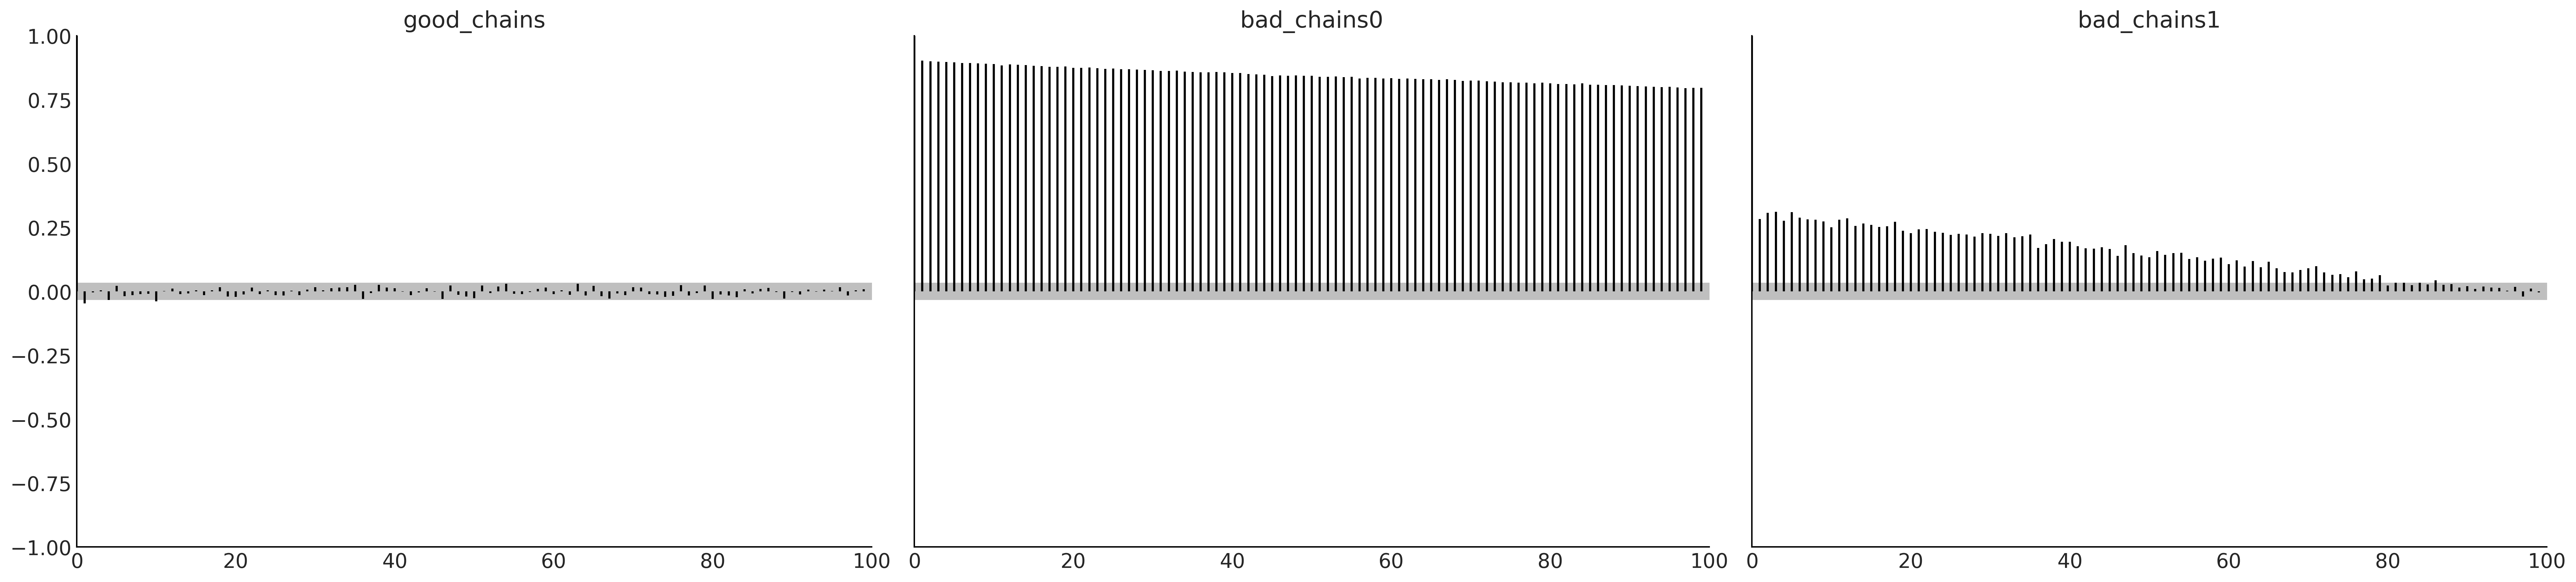

In [75]:
az.plot_autocorr(chains, combined=True)

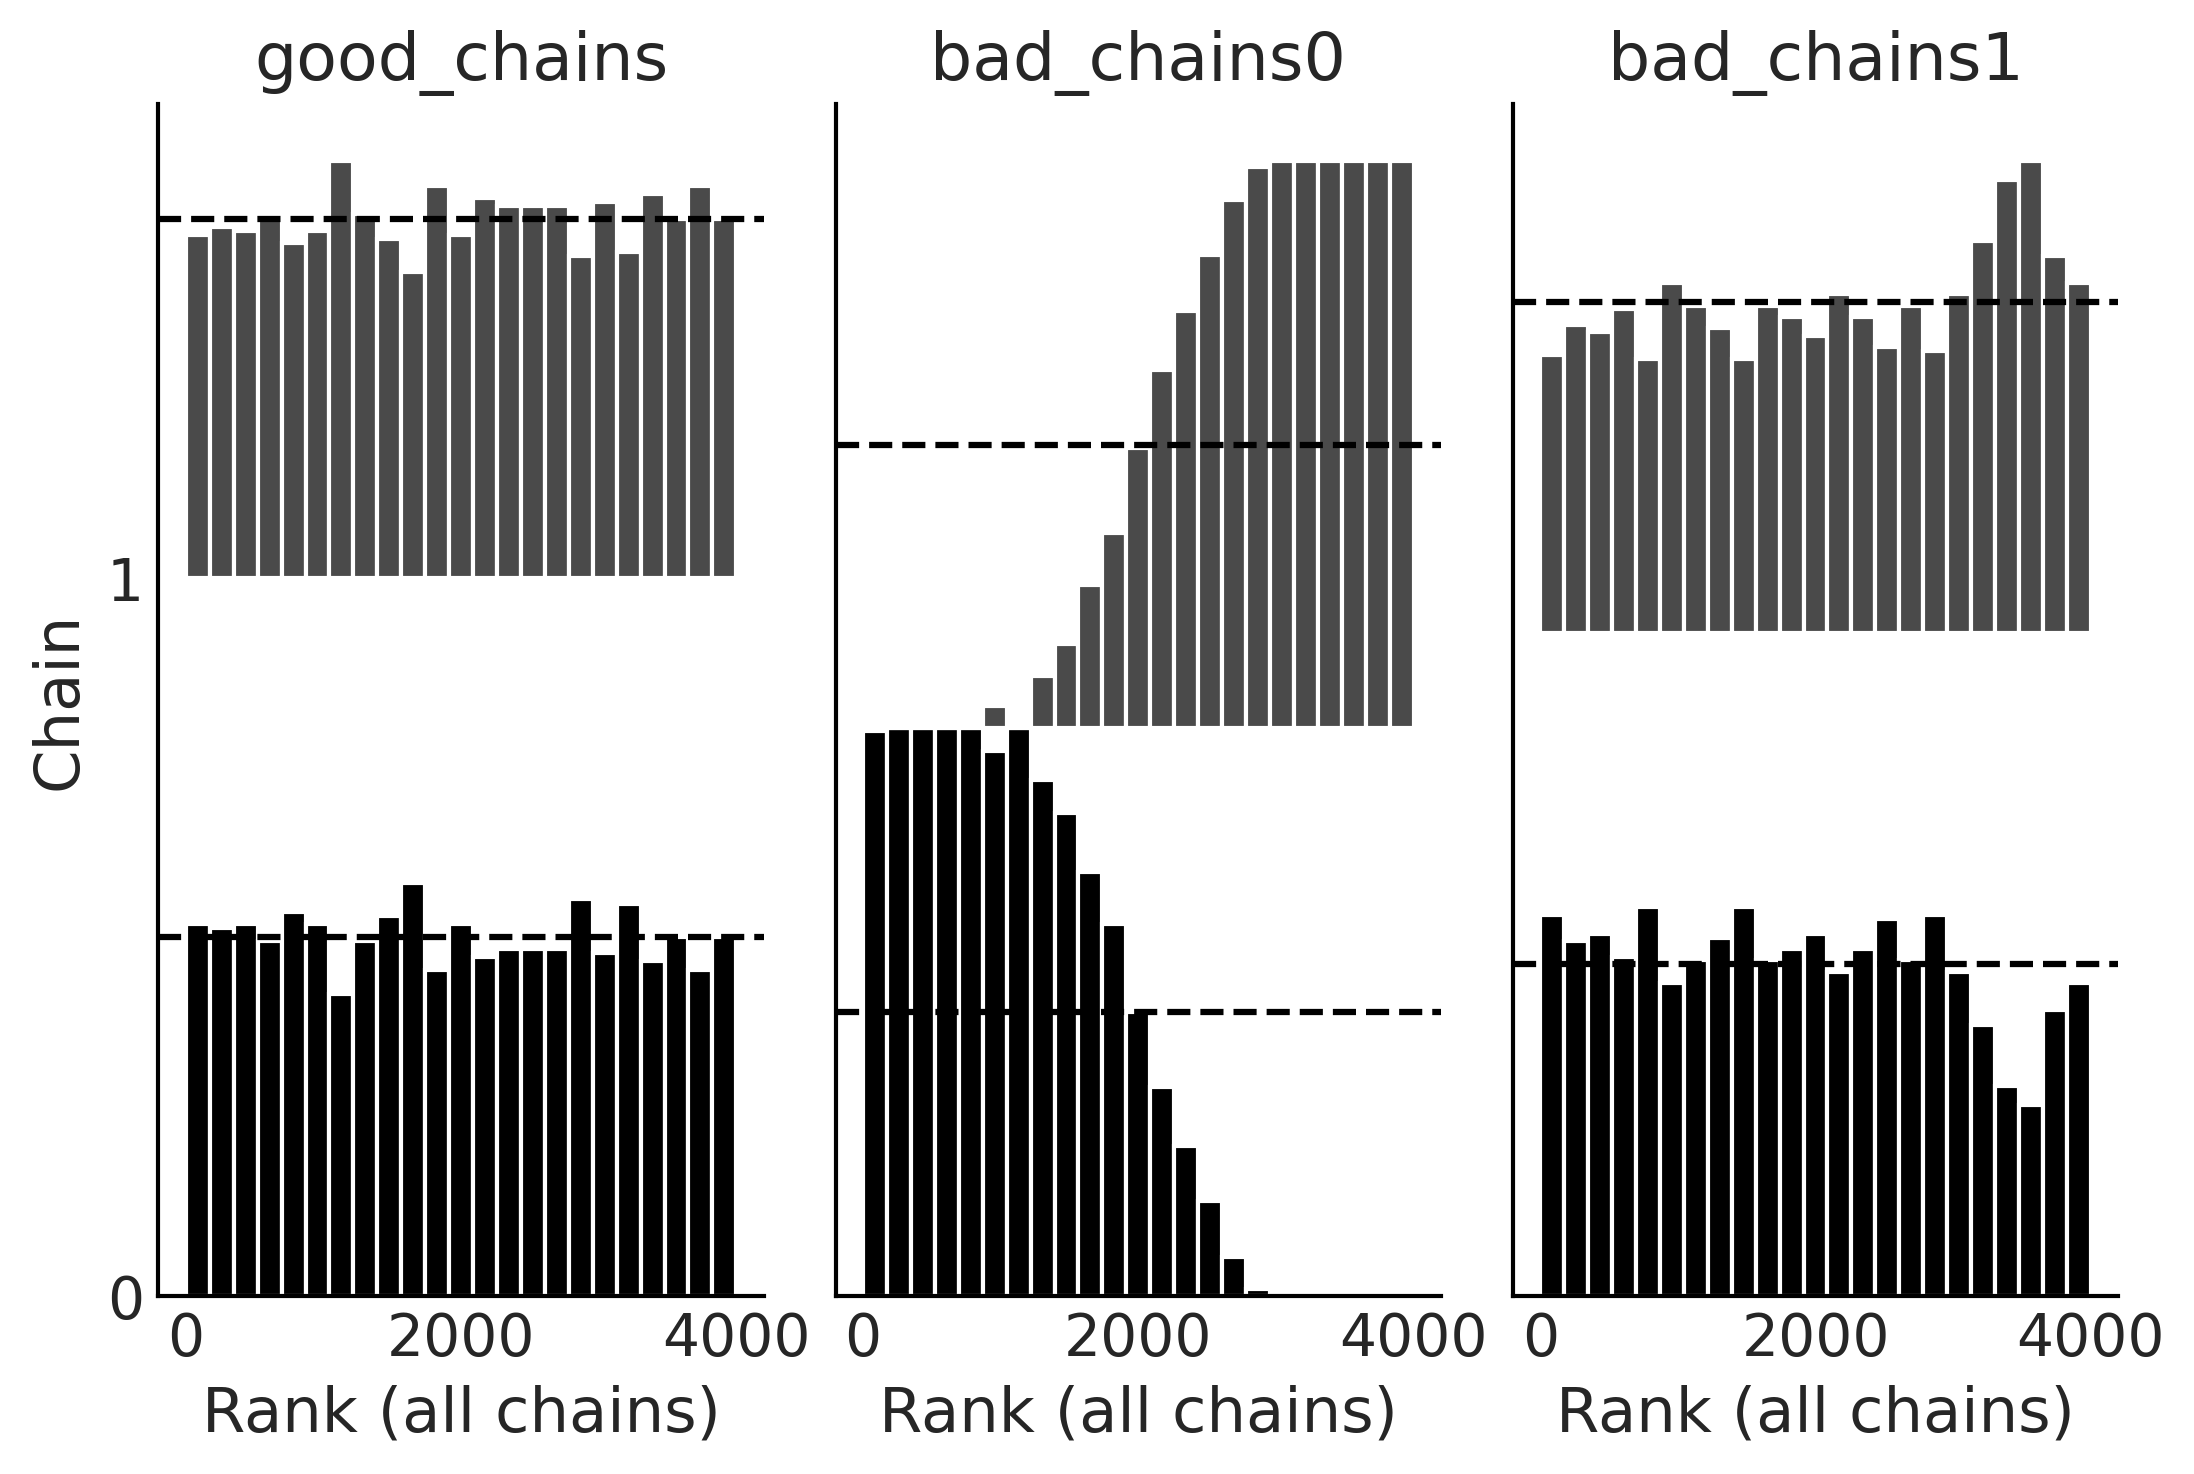

In [76]:
_, axes = plt.subplots(1, 3)
az.plot_rank(chains, kind="bars", ax=axes)
for ax_ in axes[1:]:
    ax_.set_ylabel("")
    ax_.set_yticks([])
plt.savefig('img/chap02/rank_plot_bars.png')

array([<Axes: title={'center': 'good_chains'}, xlabel='Rank (all chains)'>,
       <Axes: title={'center': 'bad_chains0'}, xlabel='Rank (all chains)'>,
       <Axes: title={'center': 'bad_chains1'}, xlabel='Rank (all chains)'>],
      dtype=object)

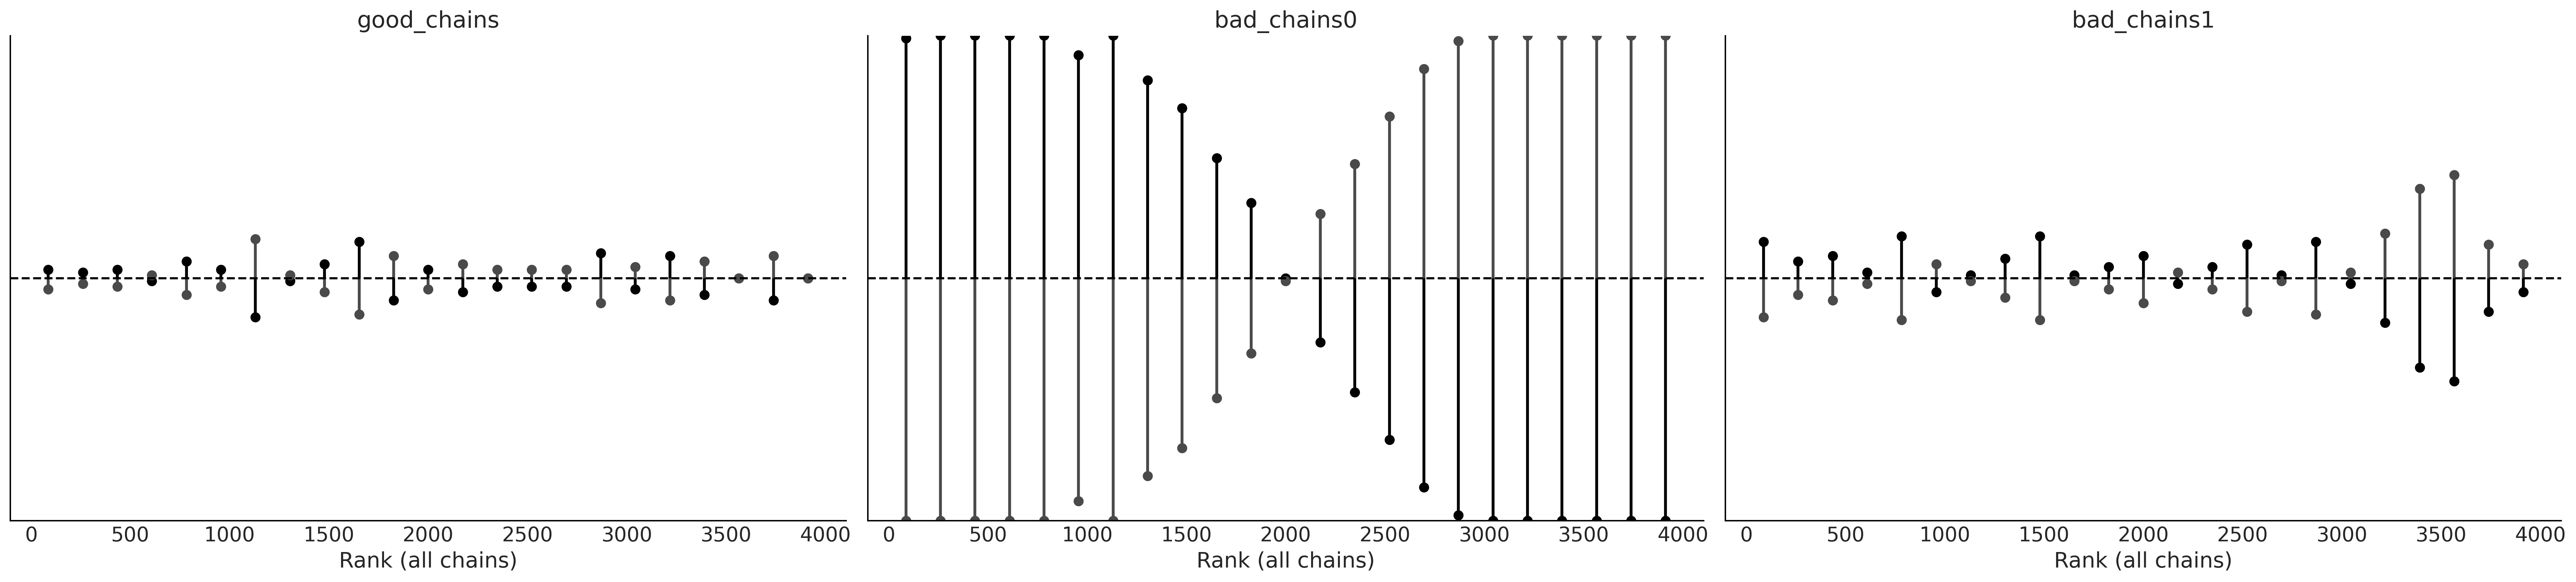

In [77]:
az.plot_rank(chains, kind="vlines")

In [86]:
with pm.Model() as model_0:
    θ1 = pm.Normal("θ1", 0, 1, initval=0.1)
    θ2 = pm.Uniform("02", -1, 1)
    idata_0 = pm.sample(return_inferencedata=True)

with pm.Model() as model_1:
    θ1 = pm.HalfNormal("θ1", 1 / (2/np.pi)**0.5)
    θ2 = pm.Uniform("θ2", -θ1, θ1)
    idata_1 = pm.sample(return_inferencedata=True)

with pm.Model() as model_1bis:
    θ1 = pm.HalfNormal("θ1", 1 / (2/np.pi)**0.5)
    θ2 = pm.Uniform("θ2", -θ1, θ1)
    idata_1bis = pm.sample(return_inferencedata=True, target_accept=0.95)

idatas = [idata_0, idata_1, idata_1bis]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ1, 02]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ1, θ2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ1, θ2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


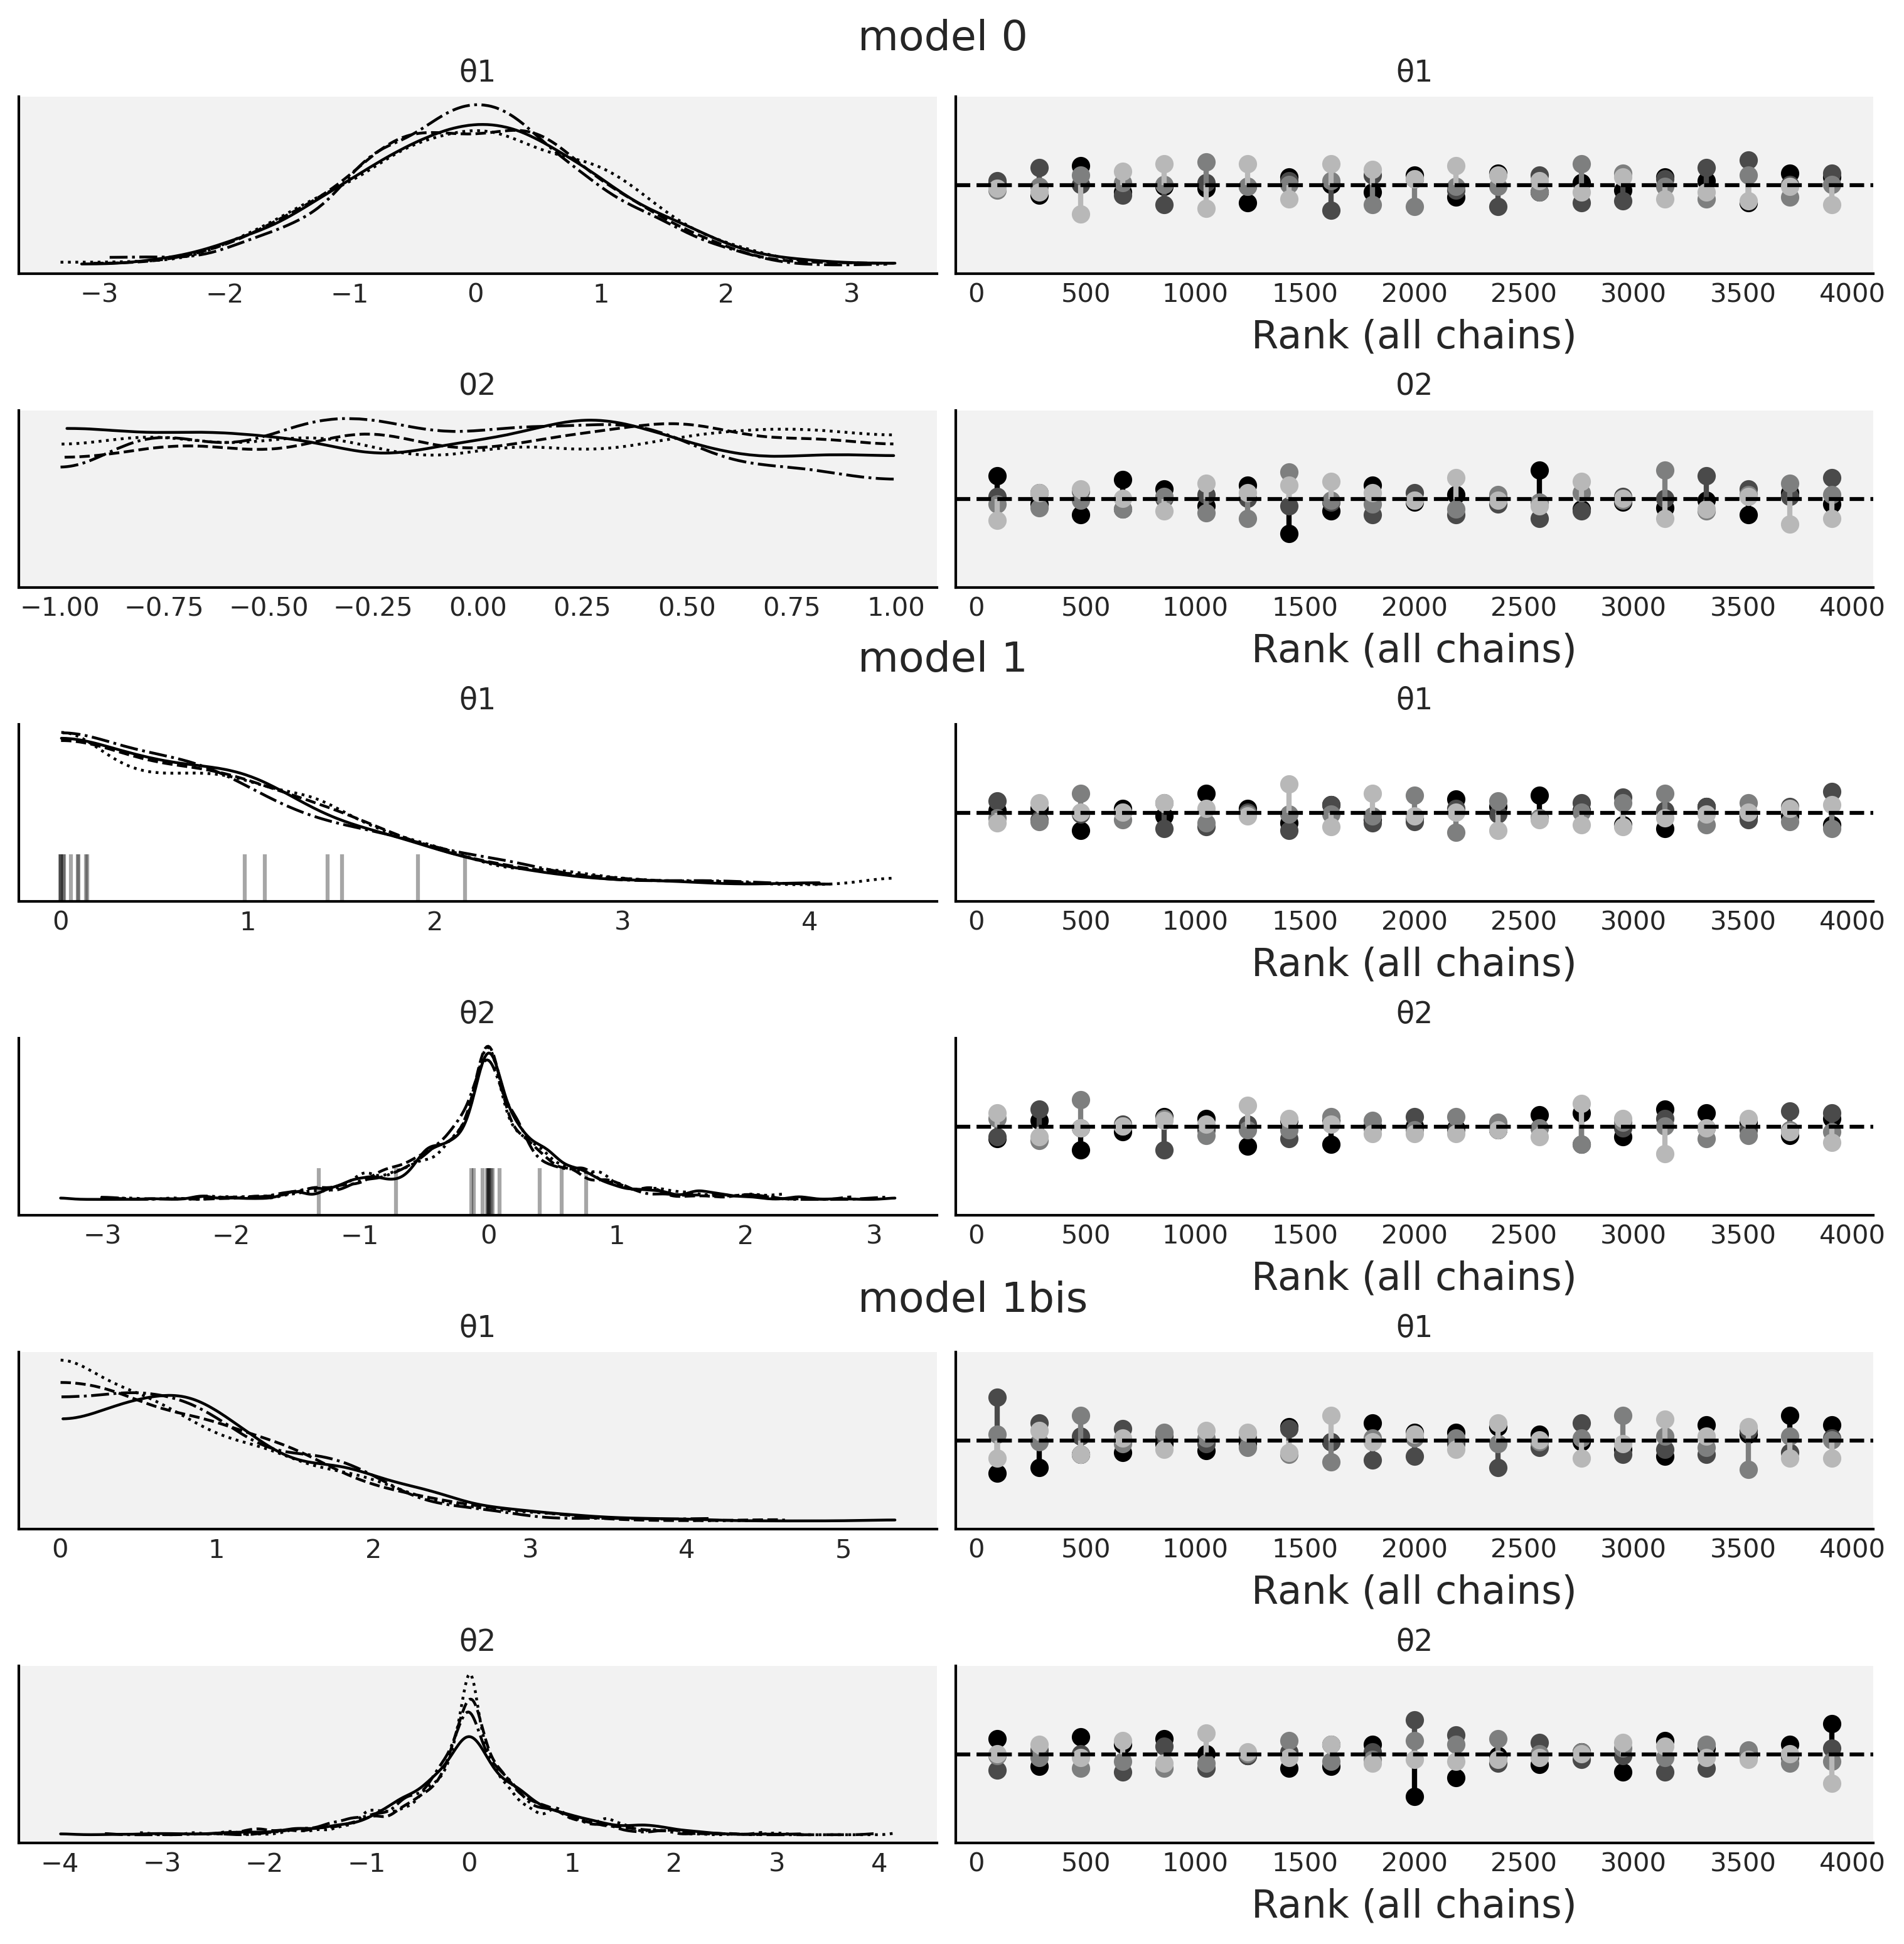

In [88]:
fig, axes = plt.subplots(6, 2, figsize=(10, 10))

axes = axes.reshape(3, 2, 2)
for idata, ax, color in zip(idatas, axes, ["0.95", "1", "0.95"]):
    az.plot_trace(idata, kind="rank_vlines", axes=ax);
    [ax_.set_facecolor(color) for ax_ in ax.ravel()]
fig.text(0.45, 1, s="model 0", fontsize=16)
fig.text(0.45, 0.67, s="model 1", fontsize=16)
fig.text(0.45, 0.33, s="model 1bis", fontsize=16)
plt.savefig("img/chap02/divergences_trace.png", bbox_inches="tight")

In [95]:
y_obs = np.random.normal(0, 1, size=100)
idatas_cmp = {}

# Generate data from Skewnormal likelihood model
# wtih fixed mean and skewness and random standard deviation
with pm.Model() as mA:
    σ = pm.HalfNormal("σ", 1)
    y = pm.SkewNormal("y", mu=0, sigma=σ, alpha=1, observed=y_obs)
    idataA = pm.sample(idata_kwargs={"log_likelihood": True})
    idataA.extend(pm.sample_posterior_predictive(idataA))
    idatas_cmp["mA"] = idataA

with pm.Model() as mB:
    σ = pm.HalfNormal("σ", 1)
    y = pm.Normal("y", 0, σ, observed=y_obs)
    idataB = pm.sample(idata_kwargs={"log_likelihood": True})
    idataB.extend(pm.sample_posterior_predictive(idataB))
    idatas_cmp["mB"] = idataB

with pm.Model() as mC:
    μ = pm.Normal("μ", 0, 1)
    σ = pm.HalfNormal("σ", 1)
    y = pm.Normal("y", μ, σ, observed=y_obs)
    idataC = pm.sample(idata_kwargs={"log_likelihood":True})
    idataC.extend(pm.sample_posterior_predictive(idataC))
    idatas_cmp["mC"] = idataC

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Sampling: [y]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Sampling: [y]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Sampling: [y]


In [99]:
cmp = az.compare(idatas_cmp)
cmp.round(2)

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
mB,0,-143.78,1.09,0.00,0.98,7.82,0.00,False,log
mC,1,-144.83,2.15,1.05,0.00,7.83,0.28,False,log
mA,2,-166.58,1.58,22.80,0.02,11.07,7.11,False,log
